In [1]:
import torch
import os
import torchvision

import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from dit import DiT

In [2]:
ckpt_path = "/root/autodl-tmp/dit_ckpt/ckpt_dit_skip_conv.pt"
checkpoint = torch.load(ckpt_path, map_location='cpu')

In [3]:
checkpoint.keys()

dict_keys(['model_ode', 'ema_ode', 'opt_ode', 'args'])

In [4]:
model_ode = DiT(
    input_size=32,
    patch_size=2,
    in_channels=3,
    out_channels=3,
    hidden_size=512,
    depth=13,
    num_heads=8,
    mlp_ratio=4,
    num_classes=0,
    use_long_skip=True,
    final_conv=True)

model_ode.eval()
model_ode.load_state_dict(checkpoint["ema_ode"])
model_ode = model_ode.to("cuda")

In [5]:
device = "cuda"

@torch.inference_mode()
def rk45(f, z0, startT=0., endT=1.0):
    def f_np(t, z, func, shape):
        z_tensor = torch.tensor(z, dtype=torch.float32, device=device).reshape(shape)
        t_tensor = t * torch.ones(shape[0], device=device)
        dz_tensor = func(z_tensor, t_tensor)   # Dit expects X_t of (B, C, H, W), and t of (B,)
        return dz_tensor.detach().cpu().numpy().reshape((-1,))
    
    shape = z0.shape
    z0_np = z0.cpu().numpy().flatten()
    t_span = (startT, endT)
    sol = solve_ivp(f_np, t_span, z0_np, args=(f, shape), method='RK45', t_eval=None, rtol=1e-3, atol=1e-3)
    z_final_np = sol.y[:, -1]
    nfe = sol.nfev
    print(f"Number of function evaluations: {nfe}")
    z_final = torch.tensor(z_final_np, dtype=torch.float32, device=device).reshape(shape)
    
    return z_final

In [6]:
# rk45 solver
z_0 = torch.randn(20, 3, 32, 32, device='cuda')
z_1 = rk45(model_ode, z_0, startT=0., endT=1.0)

Number of function evaluations: 50


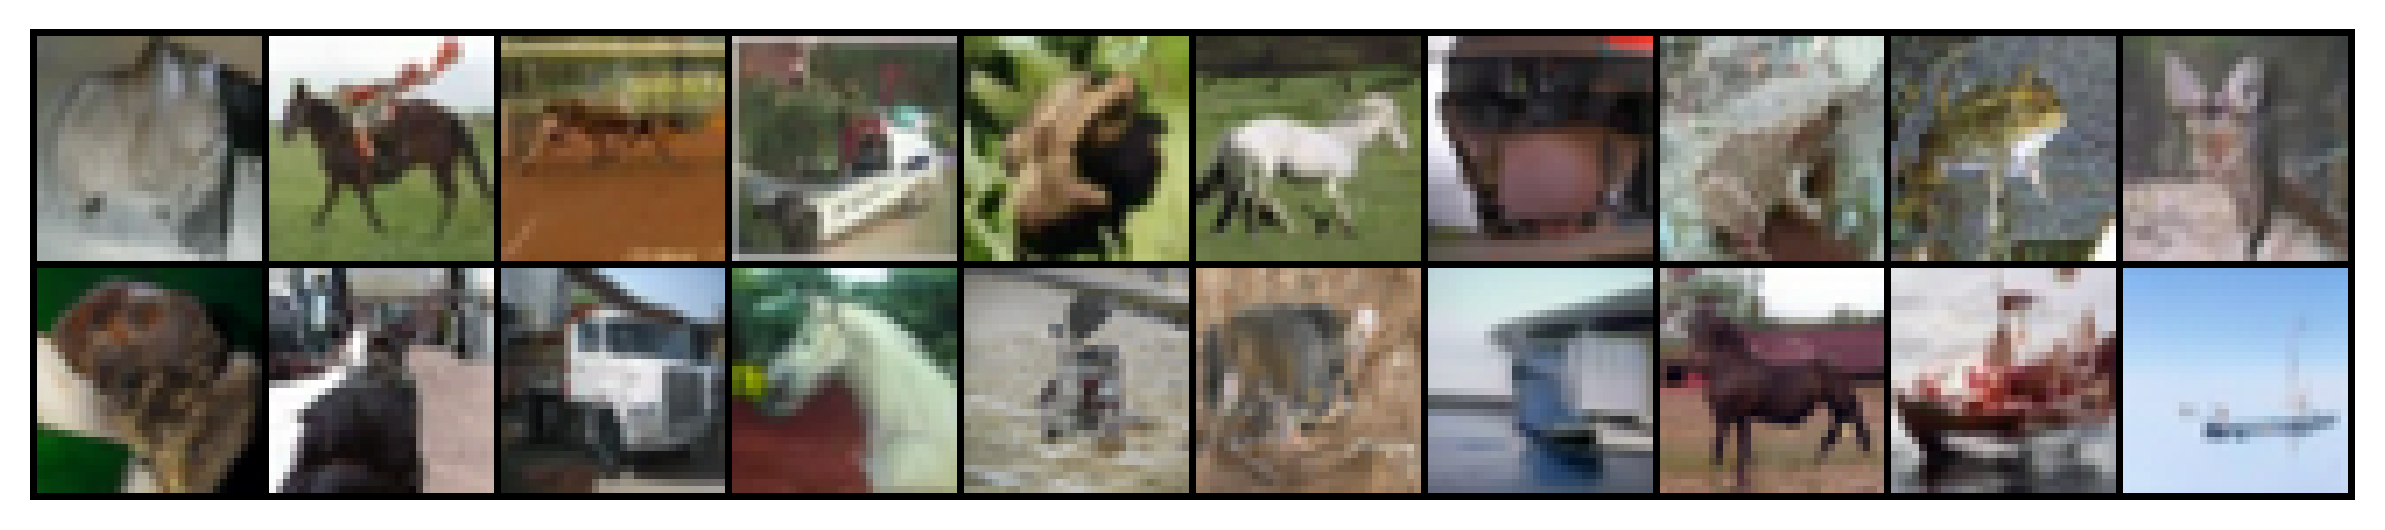

In [7]:
def plot_images(images, nrow=10):
    images = (images.cpu().detach().clone() * 0.5 + 0.5).clamp(0, 1)
    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=1, normalize=False)
    plt.figure(figsize=(10, (images.size(0) // nrow + 1) * 1.), dpi=300)
    np_grid = grid.permute(1, 2, 0).numpy()
    plt.imshow(np_grid)
    plt.axis('off')
    plt.show()
    
plot_images(z_1)

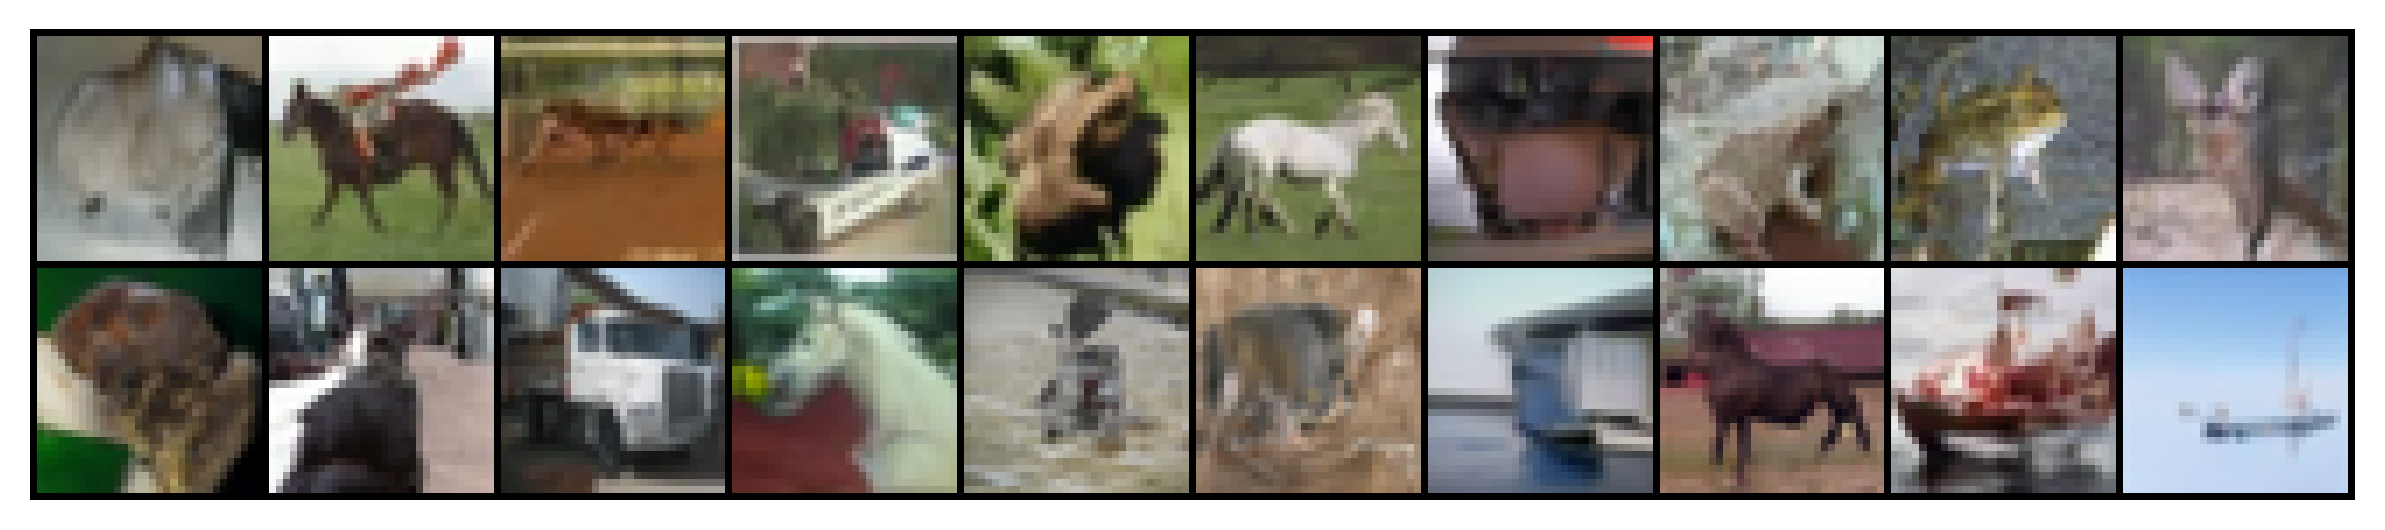

In [8]:
N = 100

with torch.inference_mode():
	z = z_0.clone()
	for i in range(N):
		v_pred = model_ode(z, torch.full((z.size(0),), i / N, device=device))
		z = z + v_pred / N

plot_images(z)